In [1]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random
using StatsFuns
using StatsPlots
default(fmt=:png)

parameter_C(P) = dot(P, P)
parameter_T(P) = sum(p -> p^3, P)
simpson_diversity_index(P) = 1 - parameter_C(P)

estimator_of_C(n, K) = sum(k -> k*(k-1), K) / (n*(n-1))
estimator_of_T(n, K) = sum(k -> k*(k-1)*(k-2), K) / (n*(n-1)*(n-2))
estimator_of_simpson_diversity_index(n, K) = 1 - estimator_of_C(n, K)

function minimum_of_estimator_of_C(n, r)
    k = n/r
    r*k*(k-1)/(n*(n-1))
end

function _coefficients_abc(n)
    a = 4(n-2)/(n*(n-1))
    b = (4n-6)/(n*(n-1))
    c = 2/(n*(n-1))
    (; a, b, c)
end

function variance_of_estimator_of_C(n, P)
    (; a, b, c) = _coefficients_abc(n)
    C = parameter_C(P)
    T = parameter_T(P)
    a*T - b*C^2 + c*C
end

std_of_estimator_of_C(n, P) = √variance_of_estimator_of_C(n, P)

function estimator_of_variance_of_estimator_of_C(n, K)
    (; a, b, c) = _coefficients_abc(n)
    Ĉ = estimator_of_C(n, K)
    T̂ = estimator_of_T(n, K)
    max(0, (a*T̂ - b*Ĉ^2 + c*Ĉ) / (1-b))
end

estimator_of_std_of_esitimator_C(n, K) = √estimator_of_variance_of_estimator_of_C(n, K)

function sim_sdi(mult::Multinomial; niters=10^5)
    n = ntrials(mult)
    sdihat = zeros(niters)
    varhat = zeros(niters)
    Ktmp = [rand(mult) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(mult, Ktmp[tid])
        sdihat[i] = estimator_of_simpson_diversity_index(n, K)
        varhat[i] = estimator_of_variance_of_estimator_of_C(n, K)
    end
    (; sdihat, varhat)
end

multinomial(K) = Multinomial(sum(K), K/sum(K)) 

function pvalue_sdi(n, K, sdi; linkfunc=identity)
    dlinkfunc(x) = ForwardDiff.derivative(linkfunc, x)
    sdihat = estimator_of_simpson_diversity_index(n, K)
    sehat = estimator_of_std_of_esitimator_C(n, K)
    z = (linkfunc(sdihat) - linkfunc(sdi)) / (abs(dlinkfunc(sdihat)) * sehat)
    2ccdf(Normal(), abs(z))
end

pvalue_sdi(K, sdi) = pvalue(sum(K), K, sdi)

function make_link_logit(n, r)
    function link_logit(x)
        m = minimum_of_estimator_of_C(n, r)
        t = (1 - m - x)/(1 - m)
        logit(t)
    end
    link_logit
end

function make_link_log(n, r)
    function link_log(x)
        m = minimum_of_estimator_of_C(n, r)
        t = 1 - m - x
        log(t)
    end
    link_log
end

function sim_pval(mult::Multinomial;
        niters=10^5,
        n = ntrials(mult),
        P = probs(mult),
        r = length(P),
        sdi = simpson_diversity_index(P),
        linkfunc0 = identity,
        linkfunc1 = make_link_logit(n, r),
        linkfunc2 = make_link_log(n, r),
    )
    n = ntrials(mult)
    pval0 = zeros(niters)
    pval1 = zeros(niters)
    pval2 = zeros(niters)
    Ktmp = [rand(mult) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(mult, Ktmp[tid])
        pval0[i] = pvalue_sdi(n, K, sdi; linkfunc=linkfunc0)
        pval1[i] = pvalue_sdi(n, K, sdi; linkfunc=linkfunc1)
        pval2[i] = pvalue_sdi(n, K, sdi; linkfunc=linkfunc2)
    end
    (; pval0, pval1, pval2)
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function plot_pval(mult::Multinomial;
        niters=10^5,
        n = ntrials(mult),
        P = probs(mult),
        r = length(P),
        sdi = simpson_diversity_index(P),
        linkfunc0 = identity,
        linkfunc1 = make_link_logit(n, r),
        linkfunc2 = make_link_log(n, r),
    )
    (; pval0, pval1, pval2) = sim_pval(mult; niters, n, P, r, sdi, linkfunc0, linkfunc1, linkfunc2)
    plot()
    plot!(α -> _ecdf(pval0, α), 0, 0.1; label="$linkfunc0")
    plot!(α -> _ecdf(pval1, α), 0, 0.1; label="$linkfunc1", ls=:dash)
    plot!(α -> _ecdf(pval2, α), 0, 0.1; label="$linkfunc2", ls=:dashdot)
    plot!(identity; label="", c=:gray, ls=:dot)
    plot!(xtick=0:0.01:1)
    plot!(size=(400, 400))
end

plot_pval (generic function with 1 method)

In [2]:
data1 = [5, 5, 5, 5]
data2 = [6, 2]
data3 = [10, 6, 2, 1, 1]
table1 = [9; 8; 7; 6; 5; 5; fill(4, 3); fill(3, 4); fill(2, 9); fill(1, 35)]
table2 = [37; 5; fill(4, 2); fill(3, 4); fill(2, 8); fill(1, 39)]
table3 = [30; 13; 9; 8; fill(7, 3); fill(6, 2); 5; fill(2, 3); fill(1, 13)]
;

n = ntrials(mult) = 117
P = probs(mult) = [0.3162393162393162, 0.042735042735042736, 0.03418803418803419, 0.03418803418803419, 0.02564102564102564, 0.02564102564102564, 0.02564102564102564, 0.02564102564102564, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.00854700854700854

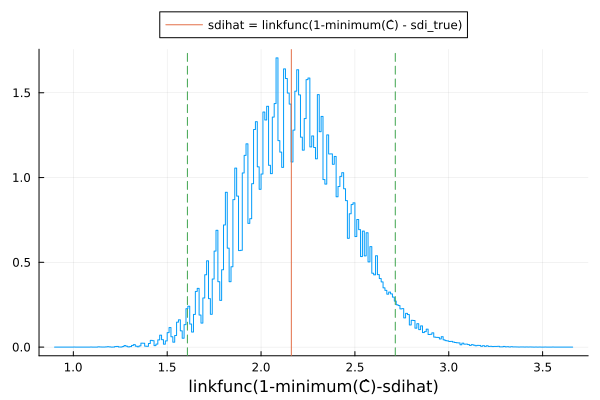

In [3]:
data = table2
mult = multinomial(data)
@show n = ntrials(mult)
@show P = probs(mult)
@show r = length(P)
@show linkfunc = make_link_logit(n, r)
dlinkfunc(x) = ForwardDiff.derivative(linkfunc, x)
@time (; sdihat, varhat) = sim_sdi(mult::Multinomial; niters=10^6)
println()
@show simpson_diversity_index(P)
@show mean(sdihat)
println()
@show variance_of_estimator_of_C(n, P)
@show var(sdihat)
@show mean(varhat)
println()
@show α = 0.05
@show w = cquantile(Normal(), α/2)
println()
@show m = minimum_of_estimator_of_C(n, r)
@show sdi_true = simpson_diversity_index(P)
@show se_true = std_of_estimator_of_C(n, P)
@show se_true_linked = abs(dlinkfunc(sdi_true)) * se_true
bin = :auto
stephist(linkfunc.((1 - m) .- sdihat); norm=true, bin, label="")
plot!(xguide="linkfunc(1-minimum(Ĉ)-sdihat)")
plot!(legend=:outertop)
vline!([linkfunc(1-m-sdi_true)]; label="sdihat = linkfunc(1-minimum(Ĉ) - sdi_true)")
vline!([linkfunc(1-m-sdi_true) - w*se_true_linked, linkfunc(1-m-sdi_true) + w*se_true_linked]; label="", ls=:dash)

data = table2 = [37, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
n = 117
r = 55
round.(P; sigdigits = 2) = [0.32, 0.043, 0.034, 0.034, 0.026, 0.026, 0.026, 0.026, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085]


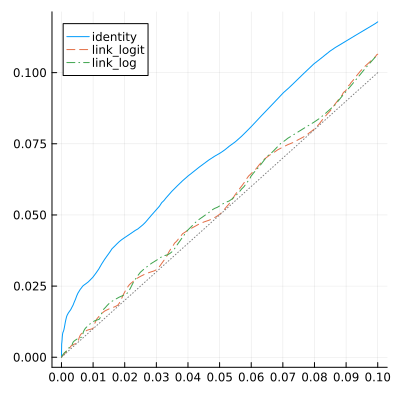

In [4]:
@show data = table2
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
plot_pval(mult)